In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms, utils
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL  import Image
import time

### Dataset Loader

#### Data Transformation

In [ ]:
class ToTorch(object):
    def __call__(self, sample):
        image , label = sample['image'], sample['label']
        #image =np.resize(image, (100,100, 3))
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image), 'label': torch.from_numpy(np.array([label]))}

#### DataSet Class

In [3]:
class CatDogDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        if(os.path.exists(os.path.join(self.root_dir, 'training_data.csv'))):
            self.csv = pd.read_csv(os.path.join(self.root_dir, 'training_data.csv'), header=None) 
            print("Found the csv!!..")
        else:
            self.create(os.path.join(self.root_dir, 'training_data.csv'))
            print("Not Found the csv!!..")
        #print(self.csv)
            
    def create(self, csv_path):
        dataset = np.array([])
        classes = os.listdir(self.root_dir)
        self.csv = []
        for i in range(len(classes)):
            self.csv.extend([[os.path.join(classes[i],j), i]for j in os.listdir(os.path.join(self.root_dir, classes[i]))])
        random.shuffle(self.csv)
        self.csv = pd.DataFrame(self.csv)
        self.csv.to_csv(csv_path, index=False, header = False)
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = os.path.join(self.root_dir, self.csv.iloc[index, 0])
        image_label = self.csv.iloc[index, 1]
        image = np.asarray(Image.open(image_name).resize((120,120), Image.ANTIALIAS))
        sample = {'image':image, 'label':image_label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

dataset = CatDogDataset(r'dataset\training_set', ToTorch())

Found the csv!!..


Length:  8000
(3, 120, 120)
Label: tensor([1])
0.057398319244384766 sec


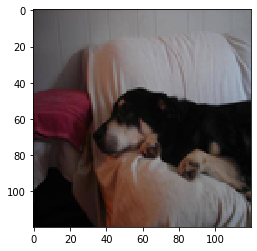

In [4]:
index = 11
t = time.time()
print('Length: ',len(dataset))
print(dataset[index]['image'].numpy().shape)
plt.imshow(dataset[index]['image'].numpy().transpose((1,2,0)))
print('Label:', dataset[index]['label'])
print(time.time()-t, 'sec')

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2)
        
        self.fc1 = nn.Linear(21632, 128)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(128,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, choice=0):
        x = self.conv1(x)
        if choice == 1:
            return x
        x = self.pool1(self.relu1(x))
        if choice == 2:
            return x
        x = self.conv2(x)
        if choice == 3:
            return x
        x = self.pool2(self.relu2(x))
        if choice == 4:
            return x
        x = self.conv3(x)
        if choice == 5:
            return x
        x = self.pool3(self.relu3(x))
        if choice == 6:
            return x
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu_fc1(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        
        return x
        
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
model = Net().cuda()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21632, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
list(model.parameters())

[Parameter containing:
 tensor([[[[-1.6193e-01,  1.5706e-01, -1.7826e-01],
           [-7.9410e-02,  1.8440e-01, -2.0822e-02],
           [ 4.3408e-02, -1.6467e-01, -1.0389e-01]],
 
          [[ 1.2546e-01, -7.1879e-02, -1.1181e-01],
           [ 1.0635e-01,  5.1866e-02,  1.1211e-01],
           [ 1.0044e-01, -2.2615e-02,  1.0952e-01]],
 
          [[ 1.6749e-01,  6.9243e-02,  8.7853e-02],
           [-1.1363e-01,  1.6389e-01, -1.2281e-01],
           [-1.1891e-01, -3.1425e-02, -1.1719e-01]]],
 
 
         [[[ 1.3480e-01,  8.9558e-02, -1.0859e-01],
           [ 1.1643e-01, -1.6398e-01,  1.5725e-01],
           [-8.7287e-03,  3.1768e-02, -1.6339e-01]],
 
          [[-2.7310e-02, -7.3270e-02, -5.8717e-02],
           [ 1.5705e-01, -1.2366e-01, -1.4399e-01],
           [ 1.8991e-01,  3.1714e-02,  1.4967e-01]],
 
          [[ 6.4713e-02,  1.6027e-02, -1.7049e-01],
           [-3.5620e-02, -7.7060e-02,  5.5370e-02],
           [ 9.2716e-02,  4.9432e-02,  7.1746e-02]]],
 
 
         [[[-1.20

In [9]:
epoc = 2
criteria = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)
dataloader = DataLoader(dataset, batch_size=80, shuffle = True)
'''
x_train = torch.Tensor(x[:20]).float().cuda()
y_train = torch.Tensor(y[:20]).float().cuda()
x_train.requires_grad_(True)
t = time.time()'''


for i in range(epoc):
    cost = 0.0
    for i_batch, sample in enumerate(dataloader):
        x_train = Variable(sample['image'].float().cuda())
        x_train.requires_grad_(True)
        #print(type(x_train))
        y_train = Variable(sample['label'].float().cuda())
        output = model(x_train)
        optimizer.zero_grad()
        loss = criteria(output, y_train)
        loss.backward()
        optimizer.step()
        cost += loss.item() 
        if(i_batch%20==0):
            print('epoch {}, batch num {}, loss {}'.format(i, i_batch, cost/20))
            cost = 0.0

print("Time taken: ", time.time()-t, "\n")

epoch 0, batch num 0, loss 0.04667375981807709
epoch 0, batch num 20, loss 13.349237298965454
epoch 0, batch num 40, loss 13.193812656402589
epoch 0, batch num 60, loss 14.005474090576172
epoch 0, batch num 80, loss 14.385400390625
epoch 1, batch num 0, loss 0.6389673709869385
epoch 1, batch num 20, loss 13.50466160774231
epoch 1, batch num 40, loss 13.521931076049805
epoch 1, batch num 60, loss 13.936396598815918
epoch 1, batch num 80, loss 13.901857566833495
Time taken:  203.6658182144165 



In [25]:
dataloader = DataLoader(dataset, batch_size=64, shuffle = True)
i_batch, sample in enumerate(dataloader)
y_predict = model(sample['image'].float().cuda())
y_predict = y_predict.cpu()
torch.sum(y_predict-sample['label'].float())/len(y_predict)

tensor(-0.5469, grad_fn=<DivBackward0>)

In [12]:
check_data = DataLoader(dataset, batch_size=1, shuffle = True)
_, sample = next(enumerate(check_data))
check_out = model(sample['image'].float().cuda(), 1)
print(check_out.shape)

torch.Size([1, 32, 118, 118])


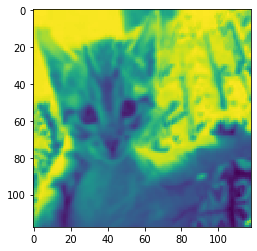

In [19]:
plt.imshow(check_out[0][4].detach().cpu().numpy())
plt.show()